# myChemometrix

#### import packages

In [1533]:
import os
import sys
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, KFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from scipy.stats import f
import numpy as np
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (14, 8)

## Parameters

In [1534]:
group_by = 'test #'               # group dataframe to split for Group K-Fold cross-validation
label_to_display = 'Cu'           # after modelling PLS the result will be shown with this selected label
selected_labels = ['Cu']            # label/s to apply PLS1/2 on
max_number_of_components = 7     # maximum number of components to allow the model
test_groups_ratio = 0.2           # the test ratio out of the total data
max_outliers = 40                 # maximum outliers to remove in the optimization process

### Import Data File (csv, xlsx)

In [1535]:
file_path = (os.getcwd() + '/data/spectra CE801 wrongCu11&12.xlsx')
# print('file path:', file_path)

### Save data as Pandas Dataframe

In [1536]:
if file_path.endswith('.csv'):
    df_raw = pd.read_csv(file_path, encoding='utf-8')
elif file_path.endswith('.xlsx'):
    df_raw = pd.read_excel(file_path)

### Inspect Raw Data

In [1537]:
print(f'Number of rows: {df_raw.shape[0]} \nNumber of columns: {df_raw.shape[1]}')

print('\nDisplay the first 5 rows of the data:')
display(df_raw.head(5))

Number of rows: 2147 
Number of columns: 114

Display the first 5 rows of the data:


,DateTime,spec #,SpecName,FluidT,SpectrT,ExpTime,start time,end time,test #,H2O2,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,2024-05-07 11:08:05,1,S7244,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2024-05-07 11:08:11,2,S7245,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,2024-05-07 11:08:17,3,S7246,23.15,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,2024-05-07 11:08:23,4,S7247,23.10,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,2024-05-07 11:08:29,5,S7248,23.10,37.25,0.048,2024-05-07 11:07:00,2024-05-07 11:25:00,1,0.4969,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


#### Remove non-numerical columns

In [1538]:
df_raw = df_raw.select_dtypes(include=['number'])
df_raw.head(5)

,spec #,FluidT,SpectrT,ExpTime,test #,H2O2,Cu,pH,A,H2O,...,1036,1038.5,1041,1043.5,1046,1048.5,1051,1053.5,1056,1058.5
0,1,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,2,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,3,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,4,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,5,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


### Check for empty cells and remove if exist

In [1539]:
flag_na = df_raw.isnull().any().any()

print(f'Any empty cells in DataFrame: {flag_na}')

if flag_na:
    df_raw = df_raw.dropna()    
    print(f'Number of rows: {df_raw.shape[0]} \nNumber of columns: {df_raw.shape[1]}')
    print('\nDisplay the first 5 rows of the data:')
    display(df_raw.head(5))

Any empty cells in DataFrame: False


### Equalize the data grouped by a label while keeping the distrabution of the measurements

In [1540]:
def equalize_group_size(df, group_column):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the smallest group
    min_group_size = grouped.size().min()
    
    # Sample data from each group to make them the same size
    equalized_data = []
    for _, group_data in grouped:
        equalized_data.append(group_data.sample(n=min_group_size, random_state=None))
    
    # Concatenate the sampled data into a new DataFrame
    equalized_df = pd.concat(equalized_data)
    
    return equalized_df


def equalize_group_size_by_padding_mean(df, group_column):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the largest group
    max_group_size = grouped.size().max()
    
    # List to hold the equalized data
    equalized_data = []
    
    for name, group_data in grouped:
        group_size = len(group_data)
        
        # Append the original group data
        equalized_data.append(group_data)
        
        # Calculate the number of rows to pad
        rows_to_add = max_group_size - group_size
        
        if rows_to_add > 0:
            # Calculate the mean values for the group's columns
            mean_values = group_data.mean()
            
            # Create a DataFrame with the mean values to pad the group
            padding_df = pd.DataFrame([mean_values] * rows_to_add, columns=group_data.columns)
            
            # Set the group column to the current group's name
            padding_df[group_column] = name
            
            # Append the padding data
            equalized_data.append(padding_df)
    
    # Concatenate the original and padded data into a new DataFrame
    equalized_df = pd.concat(equalized_data, ignore_index=True)
    
    return equalized_df

def equalize_group_size_by_padding_mean_std(df, group_column, noise_gain):
    # Group the DataFrame according to the specific column
    grouped = df.groupby(group_column)
    
    # Determine the size of the largest group
    max_group_size = grouped.size().max()
    
    # List to hold the equalized data
    equalized_data = []
    
    for name, group_data in grouped:
        group_size = len(group_data)
        
        # Append the original group data
        equalized_data.append(group_data)
        
        # Calculate the number of rows to pad
        rows_to_add = max_group_size - group_size
        
        if rows_to_add > 0:
            # Calculate the mean and std values for the group's columns
            mean_values = group_data.mean()
            std_values = noise_gain * group_data.std()
            
            # Create new rows with mean + random value between -std and +std
            padding_data = {col: np.random.uniform(mean - std, mean + std, rows_to_add) 
                            for col, mean, std in zip(group_data.columns, mean_values, std_values)}
            padding_df = pd.DataFrame(padding_data)
            
            # Set the group column to the current group's name
            padding_df[group_column] = name
            
            # Append the padding data
            equalized_data.append(padding_df)
    
    # Concatenate the original and padded data into a new DataFrame
    equalized_df = pd.concat(equalized_data, ignore_index=True)
    
    return equalized_df

# Equalize group size while preserving distribution
# df_raw = equalize_group_size(df_raw, group_by).reset_index(drop=True)
# df_raw = equalize_group_size_by_padding_mean(df_raw, group_by).reset_index(drop=True)
# df_raw = equalize_group_size_by_padding_mean_std(df_raw, group_by, 1).reset_index(drop=True)

In [1541]:
df_raw.shape

(2147, 110)

### Seperate raw data to features matrix X and targets matrix y 

* Features matrix X

1. list numeric headers from the raw dataframe

In [1542]:
# Check if the column headers are numeric
numeric_columns = [col for col in df_raw.columns if isinstance(col, (int, float))]

print(f'list of numeric headers:\n{numeric_columns}')

list of numeric headers:
[811, 813.5, 816, 818.5, 821, 823.5, 826, 828.5, 831, 833.5, 836, 838.5, 841, 843.5, 846, 848.5, 851, 853.5, 856, 858.5, 861, 863.5, 866, 868.5, 871, 873.5, 876, 878.5, 881, 883.5, 886, 888.5, 891, 893.5, 896, 898.5, 901, 903.5, 906, 908.5, 911, 913.5, 916, 918.5, 921, 923.5, 926, 928.5, 931, 933.5, 936, 938.5, 941, 943.5, 946, 948.5, 951, 953.5, 956, 958.5, 961, 963.5, 966, 968.5, 971, 973.5, 976, 978.5, 981, 983.5, 986, 988.5, 991, 993.5, 996, 998.5, 1001, 1003.5, 1006, 1008.5, 1011, 1013.5, 1016, 1018.5, 1021, 1023.5, 1026, 1028.5, 1031, 1033.5, 1036, 1038.5, 1041, 1043.5, 1046, 1048.5, 1051, 1053.5, 1056, 1058.5]


 2. remove unwanted columns if needed

In [1543]:
# uncomment if removing is needed

# # Values to remove
# values_to_remove = [811, 986]

# # Create a new list excluding the values to remove
# numeric_columns = [item for item in numeric_columns if item not in values_to_remove]

selected_x_columns = numeric_columns

3. create features matrix X

In [1544]:
X = df_raw[selected_x_columns]
print(f'Number of rows: {X.shape[0]} \nNumber of columns: {X.shape[1]}')
print('\nDisplay the first 5 rows of the data:')
display(X.head(5))

Number of rows: 2147 
Number of columns: 100

Display the first 5 rows of the data:


,811.0,813.5,816.0,818.5,821.0,823.5,826.0,828.5,831.0,833.5,...,1036.0,1038.5,1041.0,1043.5,1046.0,1048.5,1051.0,1053.5,1056.0,1058.5
0,-0.016455,-0.016218,-0.015843,-0.015277,-0.014390,-0.013066,-0.011343,-0.009393,-0.007441,-0.005761,...,-0.085526,-0.091284,-0.096095,-0.099885,-0.102702,-0.104562,-0.105331,-0.104882,-0.103389,-0.101129
1,-0.016460,-0.016223,-0.015847,-0.015279,-0.014391,-0.013067,-0.011345,-0.009394,-0.007442,-0.005759,...,-0.085513,-0.091278,-0.096091,-0.099880,-0.102692,-0.104551,-0.105322,-0.104873,-0.103375,-0.101111
2,-0.016467,-0.016231,-0.015856,-0.015289,-0.014400,-0.013075,-0.011353,-0.009402,-0.007448,-0.005765,...,-0.085530,-0.091299,-0.096108,-0.099888,-0.102688,-0.104529,-0.105290,-0.104838,-0.103345,-0.101085
3,-0.016460,-0.016224,-0.015849,-0.015283,-0.014395,-0.013071,-0.011349,-0.009398,-0.007446,-0.005764,...,-0.085500,-0.091273,-0.096092,-0.099884,-0.102696,-0.104542,-0.105296,-0.104835,-0.103333,-0.101065
4,-0.016463,-0.016226,-0.015850,-0.015284,-0.014396,-0.013071,-0.011350,-0.009401,-0.007449,-0.005766,...,-0.085476,-0.091255,-0.096079,-0.099880,-0.102707,-0.104575,-0.105347,-0.104893,-0.103383,-0.101101


* Labels matrix y

1. list non-numeric headers from the raw dataframe

In [1545]:
# Check if the column headers are non-numeric
non_numeric_columns = [col for col in df_raw.columns if not isinstance(col, (int, float))]

print(non_numeric_columns)

['spec #', 'FluidT', 'SpectrT', 'ExpTime', 'test #', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


 2. remove unwanted columns if needed

In [1546]:
# uncomment if removing is needed

# Values to remove
values_to_remove = []

# Create a new list excluding the values to remove
non_numeric_columns = [item for item in non_numeric_columns if item not in values_to_remove] 

selected_y_columns = non_numeric_columns

In [1547]:
y = df_raw[selected_y_columns]
print(f'Number of rows: {y.shape[0]} \nNumber of columns: {y.shape[1]}')
print('\nDisplay the first 5 rows of the data:')
display(y.head(5))

Number of rows: 2147 
Number of columns: 10

Display the first 5 rows of the data:


,spec #,FluidT,SpectrT,ExpTime,test #,H2O2,Cu,pH,A,H2O
0,1,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031
1,2,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031
2,3,23.15,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031
3,4,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031
4,5,23.10,37.25,0.048,1,0.4969,0.0,4.888,3.0,96.5031


## Statistical and visual inspection

* X statistical information:

In [1548]:
X.describe()

,811.0,813.5,816.0,818.5,821.0,823.5,826.0,828.5,831.0,833.5,...,1036.0,1038.5,1041.0,1043.5,1046.0,1048.5,1051.0,1053.5,1056.0,1058.5
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,...,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,0.029071,0.026251,0.023627,0.021253,0.019275,0.017822,0.016885,0.016298,0.015836,0.015243,...,-0.116872,-0.123501,-0.129112,-0.133661,-0.137198,-0.139728,-0.141136,-0.141176,-0.139862,-0.137430
std,0.036551,0.034080,0.031667,0.029317,0.027039,0.024842,0.022738,0.020727,0.018811,0.016989,...,0.025769,0.026479,0.027173,0.027857,0.028531,0.029192,0.029833,0.030340,0.030574,0.030500
min,-0.016467,-0.016231,-0.015856,-0.015298,-0.014423,-0.013111,-0.011400,-0.009461,-0.007519,-0.005844,...,-0.179471,-0.187928,-0.195339,-0.201674,-0.206969,-0.212972,-0.219900,-0.224404,-0.225967,-0.224841
25%,-0.015886,-0.015639,-0.015278,-0.014756,-0.013927,-0.012682,-0.011041,-0.009172,-0.007287,-0.005610,...,-0.118098,-0.124674,-0.130190,-0.134616,-0.138012,-0.140389,-0.141653,-0.141566,-0.140134,-0.137601
50%,0.029799,0.026945,0.024281,0.021851,0.019805,0.018274,0.017260,0.016599,0.016071,0.015423,...,-0.117357,-0.123979,-0.129557,-0.134065,-0.137553,-0.140019,-0.141349,-0.141306,-0.139912,-0.137406
75%,0.029879,0.027018,0.024345,0.021911,0.019868,0.018350,0.017350,0.016703,0.016184,0.015537,...,-0.085209,-0.091007,-0.095839,-0.099634,-0.102482,-0.104385,-0.105186,-0.104757,-0.103275,-0.101025
max,0.118189,0.109558,0.101245,0.093321,0.085965,0.079323,0.073398,0.068028,0.063004,0.058076,...,-0.084400,-0.090233,-0.095043,-0.098776,-0.101499,-0.103244,-0.103932,-0.103450,-0.101928,-0.099658


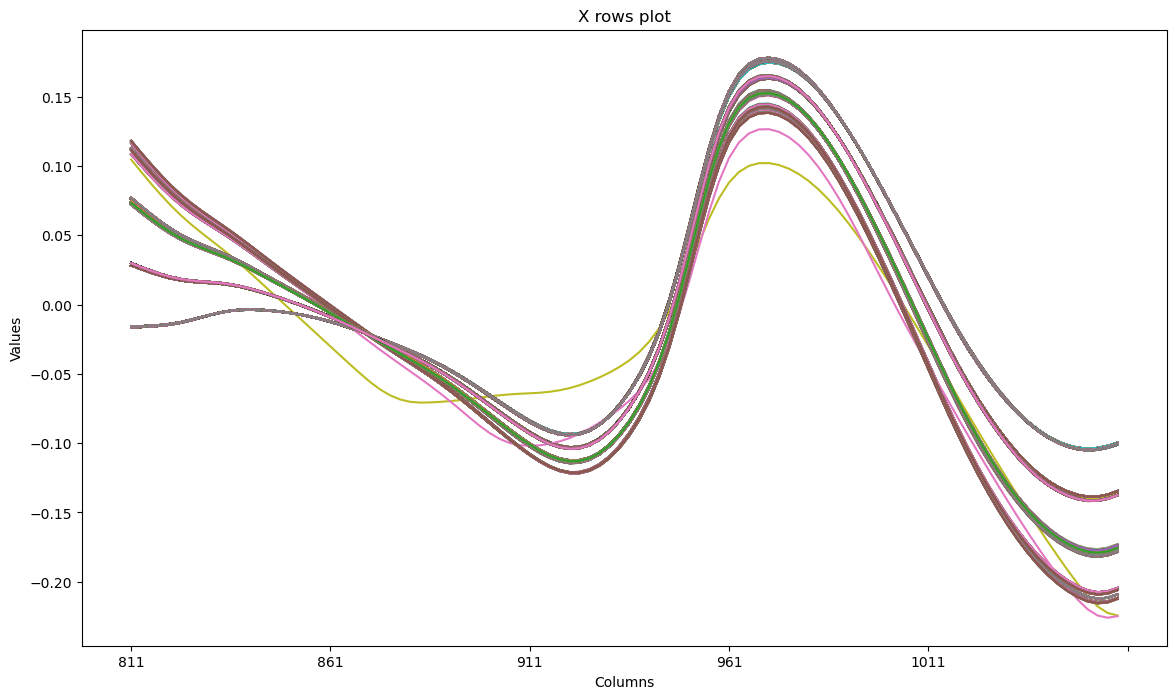

In [1549]:
X.T.plot(title='X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* y statistical information:

In [1550]:
y.describe()

,spec #,FluidT,SpectrT,ExpTime,test #,H2O2,Cu,pH,A,H2O
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,1074.000000,23.148575,37.563838,0.604647,11.084769,1.215234,709.380621,4.559796,3.401058,95.383708
std,619.929835,0.610297,0.407527,0.830257,5.662230,0.472592,591.269573,0.310400,0.315256,0.614793
min,1.000000,21.630000,36.690000,0.043000,1.000000,0.496900,0.000000,3.981000,2.885613,94.271214
25%,537.500000,22.940000,37.310000,0.048000,6.000000,0.897600,0.000000,4.508000,3.000000,94.715698
50%,1074.000000,23.190000,37.560000,0.362000,13.000000,1.049100,700.000000,4.536000,3.482989,95.602400
75%,1610.500000,23.560000,37.810000,0.377000,14.000000,1.689800,700.000000,4.876000,3.500000,95.602400
max,2147.000000,24.870000,38.440000,10.000000,21.000000,2.114400,1990.530895,5.174000,4.000000,96.503100


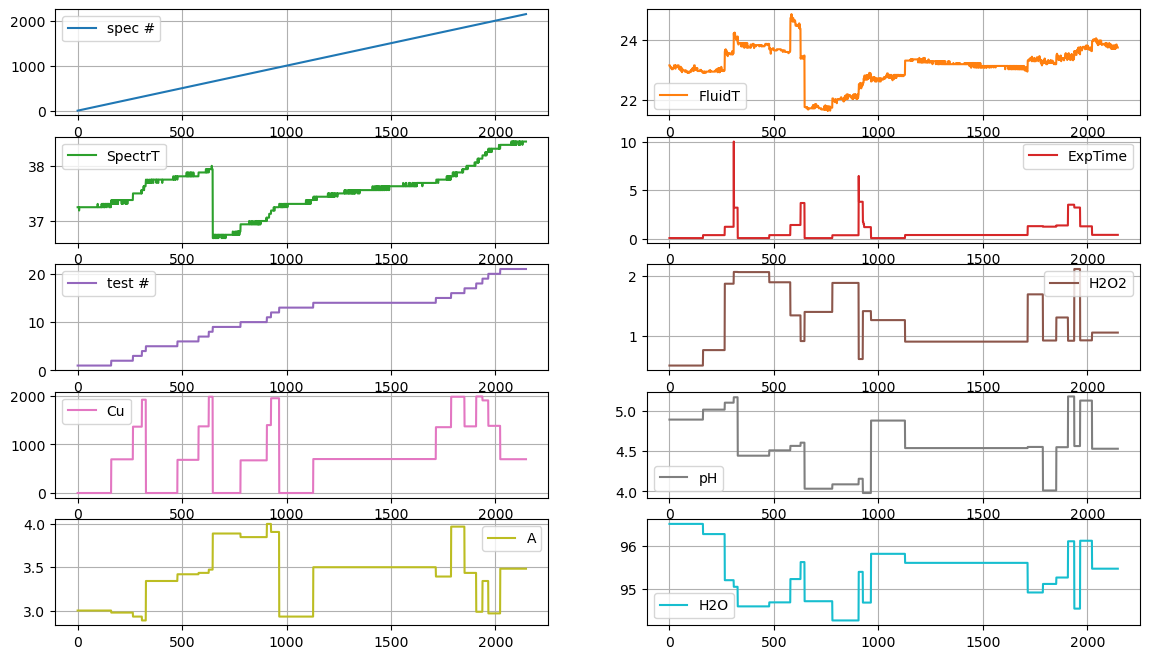

In [1551]:
fig, axes = plt.subplots(nrows=5, ncols=2)
y.plot(subplots=True, ax=axes, grid=True)
plt.show()

## Removing distance-correlation anomalies

1. Evaluate similarities using correlation-distance

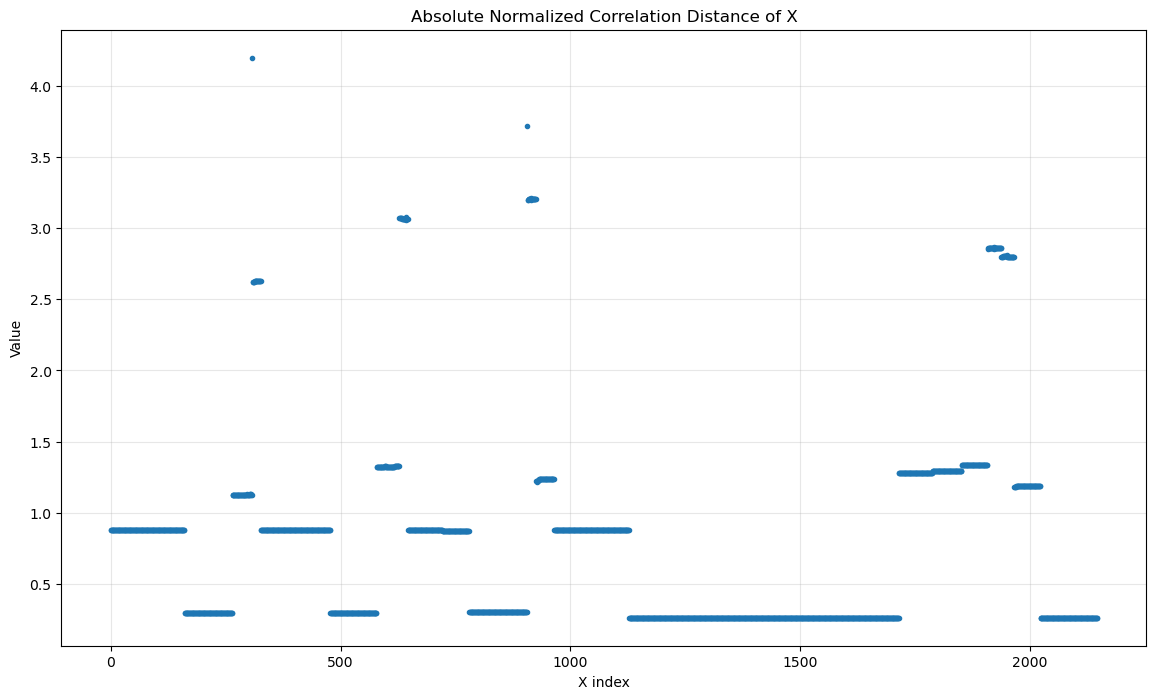

In [1552]:
dissimilarities = cdist(X, X, metric="correlation")
absolute_normalized_dissimilarities_vector = (np.abs((dissimilarities[1] - np.mean(dissimilarities[1])) / np.std(dissimilarities[1])))

plt.plot(X.index, absolute_normalized_dissimilarities_vector, '.')
plt.title('Absolute Normalized Correlation Distance of X')
plt.xlabel('X index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

2. Remove rows with values above threshold 

In [1553]:
corr_dist_threshold_high = 10
corr_dist_threshold_low = 0

In [1554]:
high_lim_rows_to_remove = np.where((absolute_normalized_dissimilarities_vector > corr_dist_threshold_high))[0]
low_lim_rows_to_remove = np.where((absolute_normalized_dissimilarities_vector < corr_dist_threshold_low))[0]

rows_to_remove = list(high_lim_rows_to_remove) + list(low_lim_rows_to_remove)

print(f'Rows to remove from data: {rows_to_remove}')

Rows to remove from data: []


3. Remove rows from X and y

In [1555]:
X_filtered = X.drop(index=rows_to_remove)
y_filtered = y.drop(index=rows_to_remove)

In [1556]:
print(f'Number of rows remained: {X_filtered.shape[0]}')

Number of rows remained: 2147


4. Visual inspection

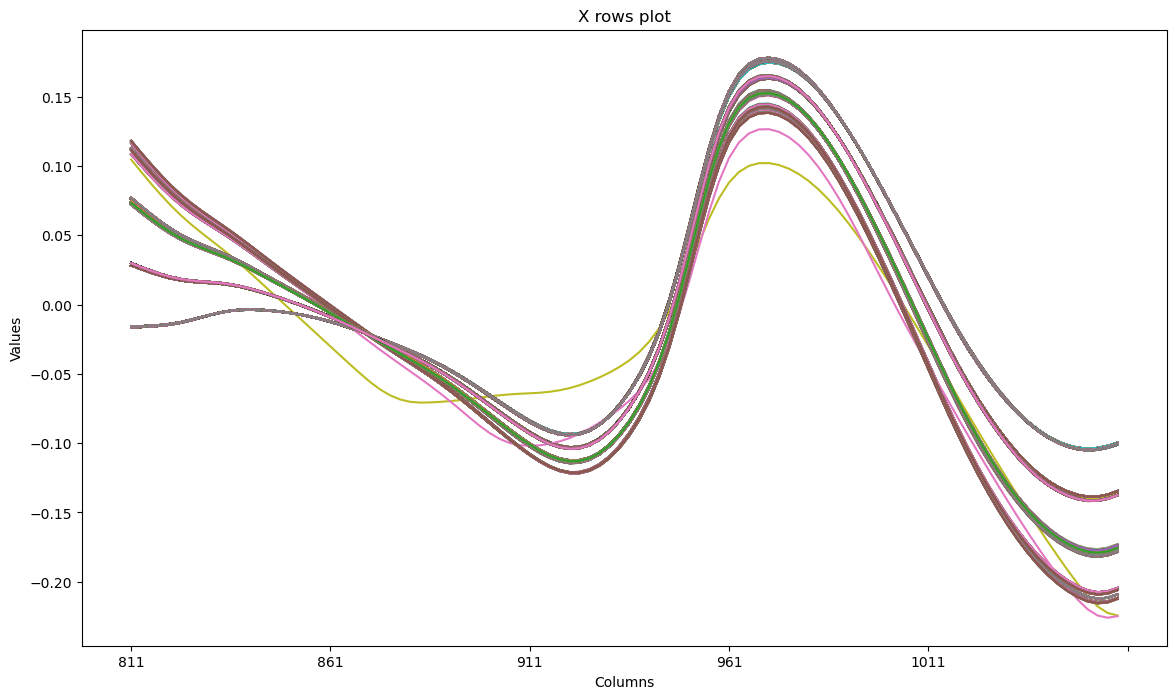

In [1557]:
X_filtered.T.plot(title='X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Removing meaurement anomalies in variables 

1. Removing meaurements which std is above threshold in each label  

In [1558]:
y_threshold = 10

In [1559]:
df_temp = pd.concat([y_filtered, X_filtered], axis=1)
for col in df_temp[y_filtered.columns]:
    mean = df_temp[col].mean()
    std = df_temp[col].std()
    df_temp = df_temp[(df_temp[col] - mean).abs() <= (y_threshold * std)]


df_temp = df_temp.dropna()
df_temp = df_temp.reset_index(drop=True)

X_filtered = df_temp[selected_x_columns]
y_filtered = df_temp[selected_y_columns]

print(f'Number of rows remained: {X_filtered.shape[0]}')

Number of rows remained: 2146


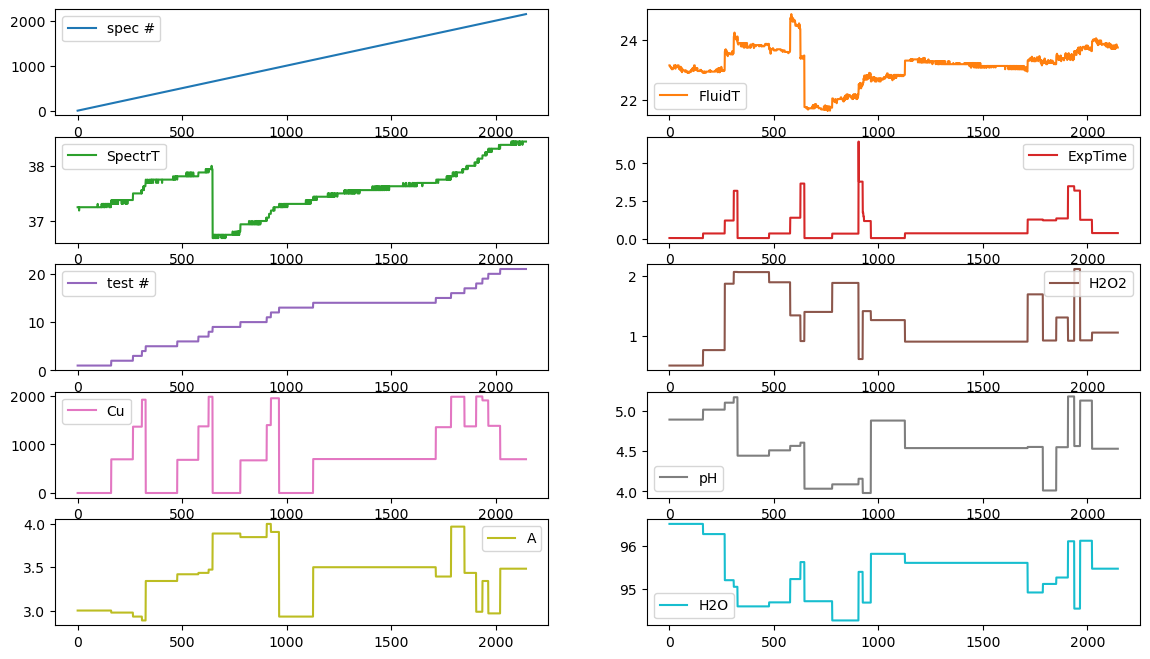

In [1560]:
fig, axes = plt.subplots(nrows=5, ncols=2)
y_filtered.plot(subplots=True, ax=axes)
plt.show()

## Calulating 1st and 2nd orders derivatives 

In [1561]:
# Calculate derivatives
X1 = pd.DataFrame(savgol_filter(X_filtered, 11, polyorder = 2, deriv=1), columns=X.columns)
X2 = pd.DataFrame(savgol_filter(X_filtered, 11, polyorder = 2,deriv=2), columns=X.columns)

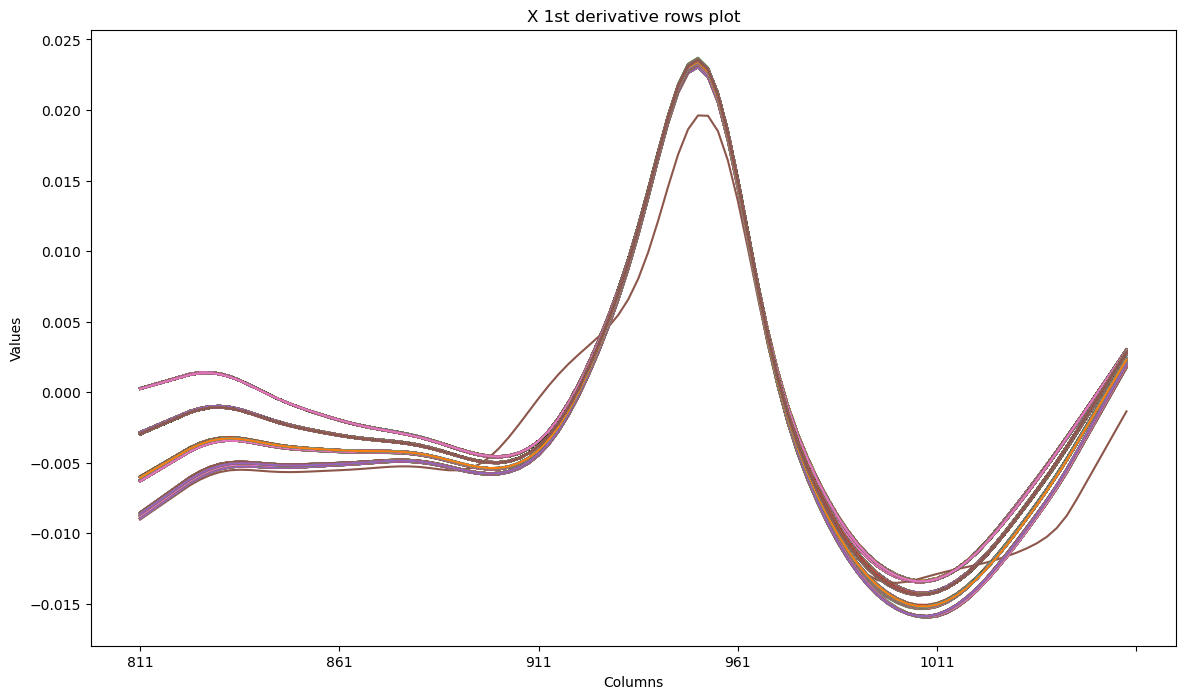

In [1562]:
X1.T.plot(title='X 1st derivative rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

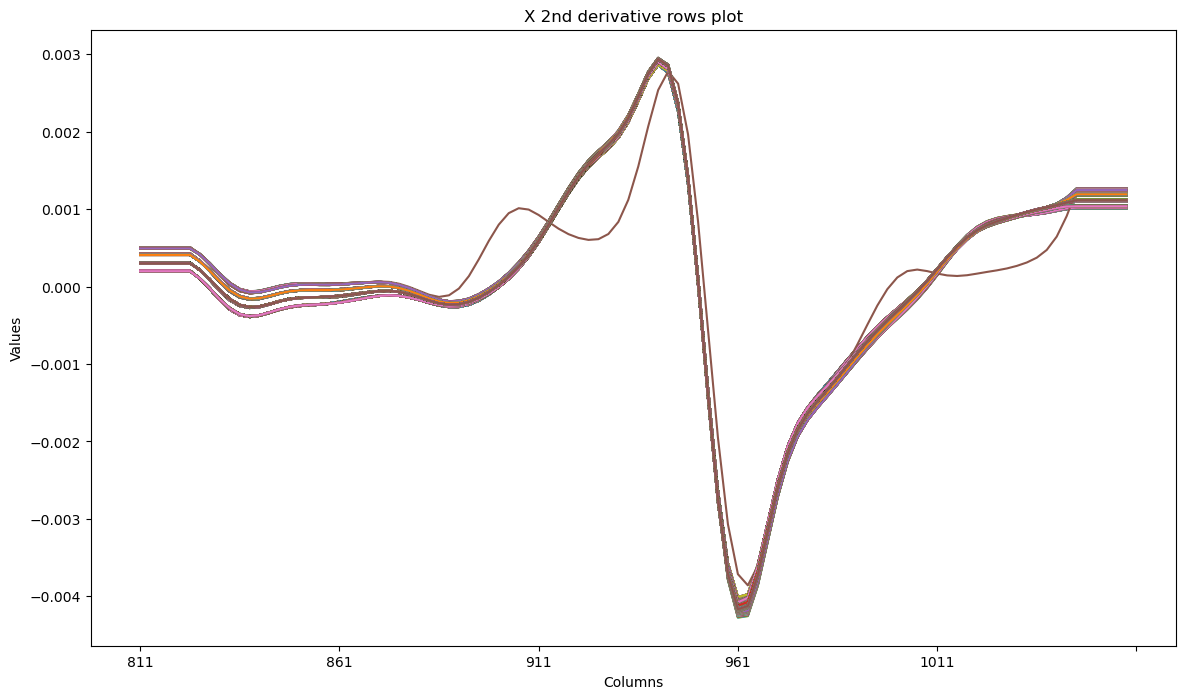

In [1563]:
X2.T.plot(title='X 2nd derivative rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Apply MSC

In [1564]:
pd.options.mode.chained_assignment = None

def apply_msc(_x):
    """
    Apply Multiplicative Scatter Correction (MSC) to NIR spectra.
    """
    temp_input = _x
    for i in range(temp_input.shape[0]):
        temp_input.iloc[i] -= temp_input.iloc[i].mean()

    ref = np.mean(temp_input, axis=0)

    # Define a new array and populate it with the corrected data
    data_msc = temp_input.copy()
    for i in range(temp_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, temp_input.iloc[i, :], 1, full=True)

        # Apply correction
        data_msc.iloc[i, :] = (temp_input.iloc[i, :] - fit[0][1]) / fit[0][0]

    Xmsc = data_msc.copy()

    return Xmsc

Xmsc = apply_msc(X_filtered)

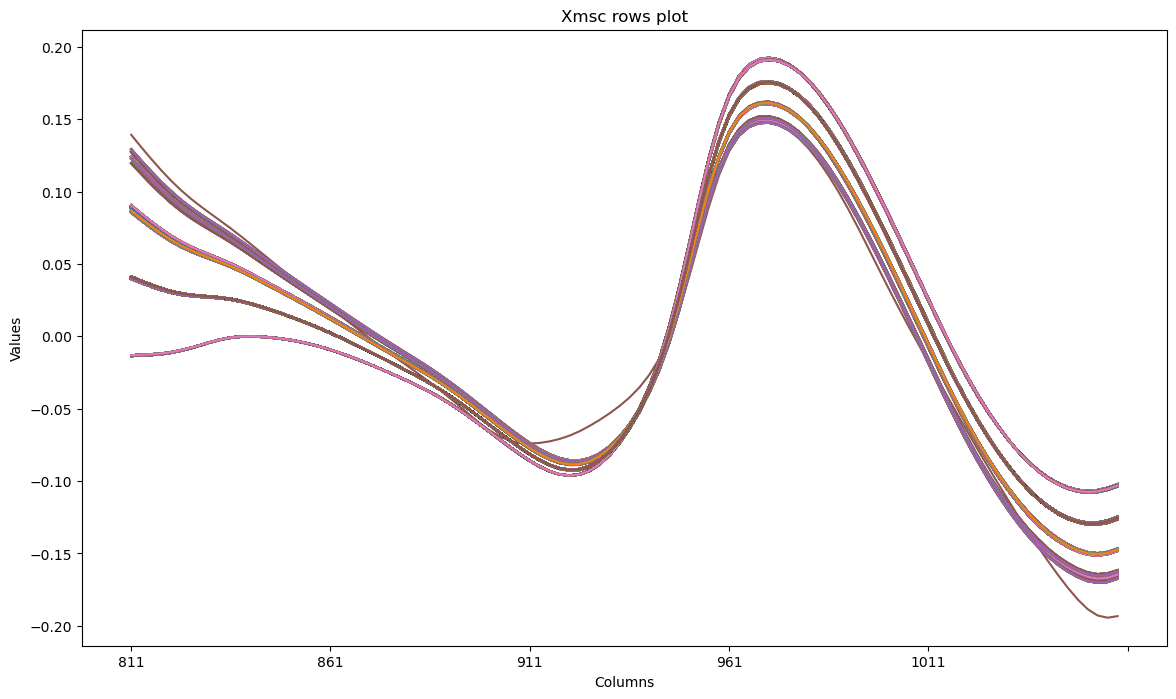

In [1565]:
Xmsc.T.plot(title='Xmsc rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

## Spliting the data into training and testing subsets

1. Define Group K-fold for the splitting train and test datasets

In [1566]:
total_number_of_groups = y_filtered[group_by].nunique()
total_test_groups = int(np.ceil((test_groups_ratio)*total_number_of_groups)) 
total_train_groups = total_number_of_groups - total_test_groups

print(f'Total number of groups of label "{group_by}" = {total_number_of_groups}')
print(f'Total number of train groups = {total_train_groups}')
print(f'Total number of test groups = {total_test_groups}')

# Define GroupKFold
# gkf_test = KFold(n_splits=total_test_groups)
gkf_test = GroupShuffleSplit(n_splits=total_test_groups)
# gkf_test = GroupKFold(n_splits=total_test_groups)

Total number of groups of label "test #" = 21
Total number of train groups = 16
Total number of test groups = 5


2. split the data into train and test datasets

In [1567]:
chosen_X = X_filtered
chosen_y = y_filtered

for train_index, test_index in gkf_test.split(chosen_X, chosen_y, chosen_y[group_by]):
    x_train, x_test = chosen_X.iloc[train_index], chosen_X.iloc[test_index]
    y_train, y_test = chosen_y.iloc[train_index], chosen_y.iloc[test_index]

* summary

In [1568]:
print('Total data: ', x_train.shape[0] + x_test.shape[0])
print('Train data: ', x_train.shape[0])
print('Test data: ', x_test.shape[0])

Total data:  2146
Train data:  1334
Test data:  812


## Standardize the data using StandardScaler

* Create StandardScaler instance for train,cv and test data

In [1569]:
########################## -- uncomment to scale -- #############################################
# # Initialize StandardScaler
# scaler = StandardScaler()

# # Fit the scaler on the data and transform the data
# y_train_scaled = scaler.fit_transform(y_train)
# x_train_scaled = scaler.fit_transform(x_train.T)

# y_test_scaled = scaler.fit_transform(y_test)
# x_test_scaled = scaler.fit_transform(x_test.T)

# # Convert the scaled data back to a DataFrame with original column names
# y_train_scaled = pd.DataFrame(y_train_scaled, columns=y.columns)
# x_train_scaled = pd.DataFrame(x_train_scaled.T, columns=X.columns)

# y_test_scaled = pd.DataFrame(y_test_scaled, columns=y.columns)
# x_test_scaled = pd.DataFrame(x_test_scaled.T, columns=X.columns)

##################################### -- comment to scale -- ##################################################

y_train_scaled = pd.DataFrame(y_train, columns=y.columns)
x_train_scaled = pd.DataFrame(x_train, columns=X.columns)

y_test_scaled = pd.DataFrame(y_test, columns=y.columns)
x_test_scaled = pd.DataFrame(x_test, columns=X.columns)

* X Train set

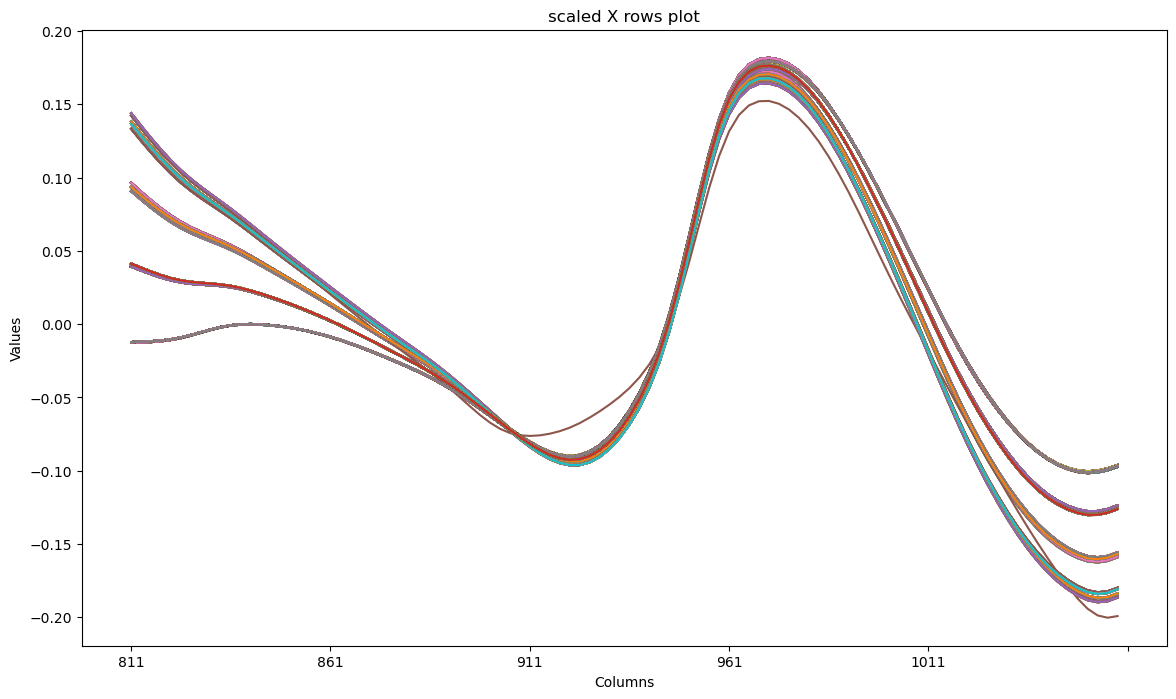

In [1570]:
x_train_scaled.T.plot(title='scaled X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* X test set

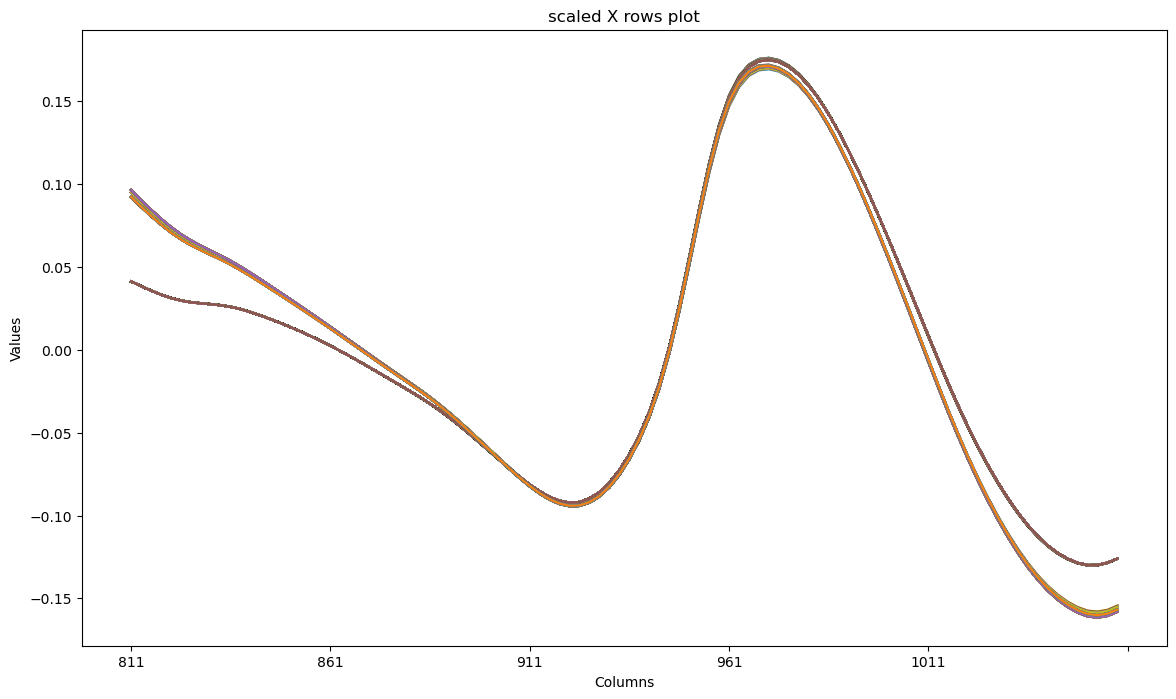

In [1571]:
x_test_scaled.T.plot(title='scaled X rows plot', xlabel='Columns', ylabel='Values', legend=False)
plt.show()

* y train set

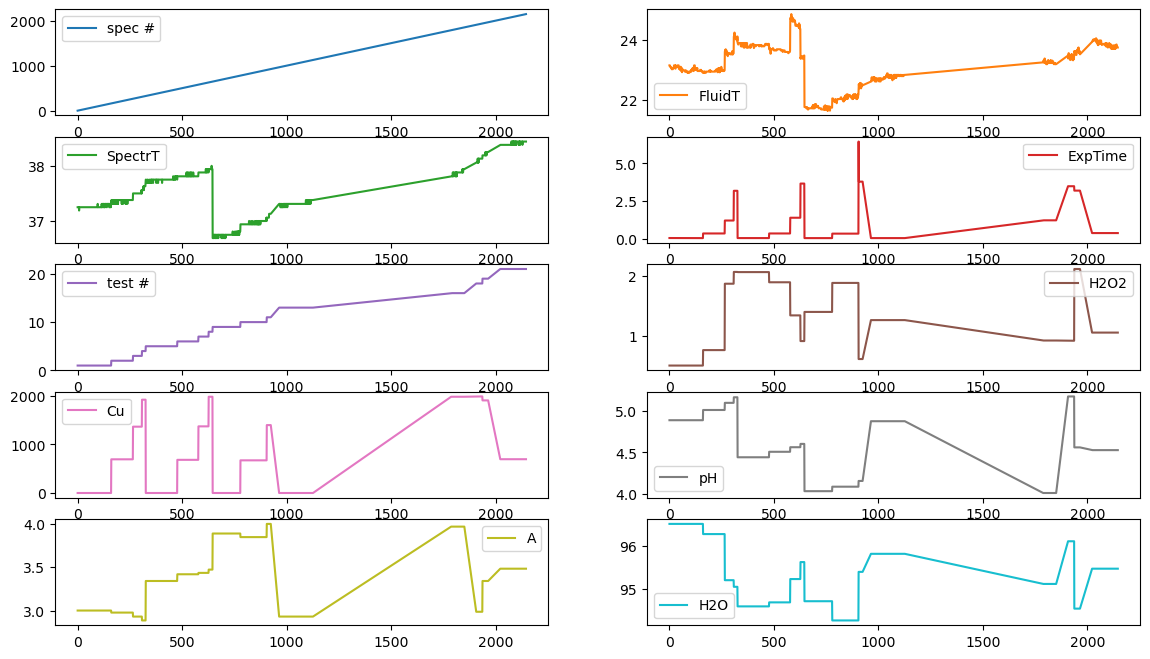

In [1572]:
fig, axes = plt.subplots(nrows=5, ncols=2)
y_train_scaled.plot(subplots=True, ax=axes)
plt.show()

* y test set

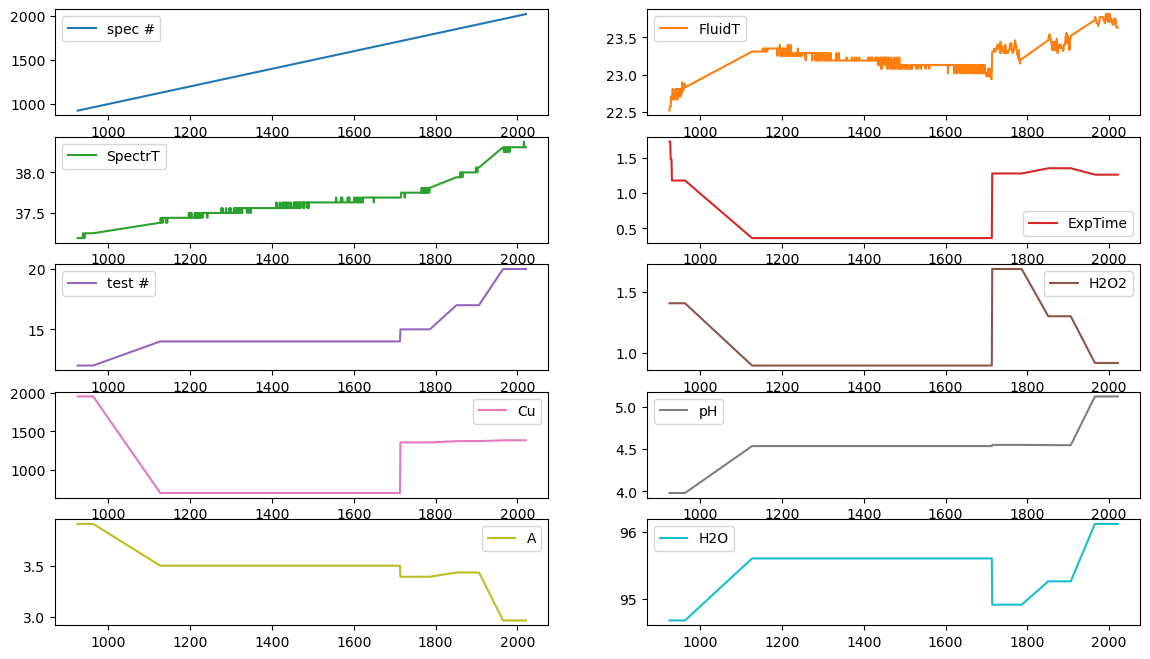

In [1573]:
fig, axes = plt.subplots(nrows=5, ncols=2)
y_test_scaled.plot(subplots=True, ax=axes)
plt.show()

# PLS Regression

#### Select the labels to apply the model on

In [1574]:
print(y.columns.tolist())

['spec #', 'FluidT', 'SpectrT', 'ExpTime', 'test #', 'H2O2', 'Cu', 'pH', 'A', 'H2O']


In [1575]:
x_pls_train = x_train.copy()
y_pls_train = y_train[selected_labels].copy()
y_pls_test = y_test[selected_labels].copy()
pls_group_train = y_train[group_by].copy()
pls_group_test = y_test[group_by].copy()

print(f'The features matrix to be modeled x_pls shape: {x_pls_train.shape}')
print(f'The labels matrix to be modeled y_pls shape: {y_pls_train.shape}')

The features matrix to be modeled x_pls shape: (1334, 100)
The labels matrix to be modeled y_pls shape: (1334, 1)


### Finding the best number of components for the model

1. Define the parameter space for the search

In [1576]:
parameters = {'n_components':np.arange(1,max_number_of_components + 1,1)}

2. Define the grid-search estimator based on PLS regression

* define group k-fold

In [1577]:
# Define GroupKFold cross-validation
group_kfold = GroupKFold(n_splits=total_train_groups - 1)
print(f'Group K-Fold: {group_kfold}')

Group K-Fold: GroupKFold(n_splits=15)


In [1578]:
pls = GridSearchCV(PLSRegression(scale=True), parameters, scoring = 'neg_mean_squared_error', verbose=1, cv=group_kfold)

3. fit the model to the training data

In [1579]:
pls.fit(x_pls_train, y_pls_train, groups=pls_group_train)

Fitting 15 folds for each of 7 candidates, totalling 105 fits


GridSearchCV(cv=GroupKFold(n_splits=15), estimator=PLSRegression(),
             param_grid={'n_components': array([1, 2, 3, 4, 5, 6, 7])},
             scoring='neg_mean_squared_error', verbose=1)

4. The best estimator result

In [1580]:
print(f'The number of components for the PLS model: \n{pls.best_estimator_}')

The number of components for the PLS model: 
PLSRegression(n_components=1)


4. Self prediction results

In [1581]:
y_pred_train = pls.predict(x_pls_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=selected_labels)

print(f'The self prediction matrix y_pred_train shape: {y_pred_train.shape}')

The self prediction matrix y_pred_train shape: (1334, 1)


In [1582]:
rmse_train, r2_train = np.sqrt(mean_squared_error(y_pls_train[label_to_display], y_pred_train[label_to_display])), \
                               r2_score(y_pls_train[label_to_display], y_pred_train[label_to_display])

### Applying cross validation for the model using the best estimator

1. Apply the best estimator to calculate a cross-validation predicted variable

In [1583]:
y_pred_cv = cross_val_predict(pls.best_estimator_, x_pls_train, y_pls_train, groups=pls_group_train, cv=group_kfold)
y_pred_cv = pd.DataFrame(y_pred_cv, columns=selected_labels)

print(f'The cross-validation prediction matrix y_cv shape: {y_pred_cv.shape}')

The cross-validation prediction matrix y_cv shape: (1334, 1)


2. Calculate figures of merit

In [1584]:
rmse_cv, r2_cv = np.sqrt(mean_squared_error(y_pls_train[label_to_display], y_pred_cv[label_to_display])),\
                                            r2_score(y_pls_train[label_to_display], y_pred_cv[label_to_display])

### Validating the model using Test dataset

In [1585]:
y_pred_test = pls.predict(x_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=selected_labels)

In [1586]:
rmse_test, r2_test = np.sqrt(mean_squared_error(y_pls_test[label_to_display], y_pred_test[label_to_display])),\
                                                r2_score(y_pls_test[label_to_display], y_pred_test[label_to_display])

3. Plot the results

In [1587]:
def regression_plot(y_train, y_pred_train, y_pred_cv, y_test, y_pred_test, rmse_train, r2_train, \
                    rmse_cv, r2_cv, rmse_test, r2_test, title = None, variable = None):
 
    # Regression plot
 
    z_train = np.polyfit(y_train.values, y_pred_train.values, 1)
    z_cv = np.polyfit(y_train.values, y_pred_cv.values, 1)
    z_test = np.polyfit(y_test.values, y_pred_test.values, 1)

    
    with plt.style.context(('seaborn-v0_8-white')):
        fig, ax = plt.subplots(figsize=(16, 9))
        
        # Creating the legend table
        legend_table = ax.table(
            cellText=[[f'Train', f'{rmse_train:.6f}', f'{r2_train:.6f}', f'{z_train[0]:.6f}'],
                      [f'CV', f'{rmse_cv:.6f}', f'{r2_cv:.6f}', f'{z_cv[0]:.6f}'],
                      [f'Test', f'{rmse_test:.6f}', f'{r2_test:.6f}', f'{z_test[0]:.6f}']],
            colLabels=['', 'RMSE', 'R-Square', 'Slope'],
            loc='upper left',
            cellLoc='center',
            cellColours=[['w', 'b', 'b', 'b'], ['w', 'r', 'r', 'r'], ['w', 'g', 'g', 'g']])

        # Styling the legend table
        legend_table.auto_set_font_size(False)
        legend_table.set_fontsize(10)
        legend_table.scale(0.4, 1.2) 
    
        ax.scatter(y_train, y_pred_train, c='blue', edgecolors='k', alpha=0.75, label='Train')
        ax.scatter(y_train, y_pred_cv, c='red', edgecolors='k', alpha=0.5, label='Cross Validation')
        ax.scatter(y_test, y_pred_test, c='green', edgecolors='k', alpha=0.3, label='Test')
        ax.plot(y_train, z_train[1]+z_train[0]*y_train, c='blue', linewidth=1, label='Model line')
        ax.plot(y_train, z_cv[1]+z_cv[0]*y_train, c='red', linewidth=1, label='CV line')
        ax.plot(y_test, z_test[1]+z_test[0]*y_test, c='green', linewidth=1, label='Test line')
        ax.plot(y_train, y_train, color='k', linewidth=1, label='Ideal line')
 
        if title is not None:
            plt.title(title, fontsize=12)
        if variable is not None:
            plt.xlabel('Measured ' + variable, fontsize=12)
            plt.ylabel('Predicted ' + variable, fontsize=12)
 
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.2)
        plt.legend(loc='lower right')
    plt.show()

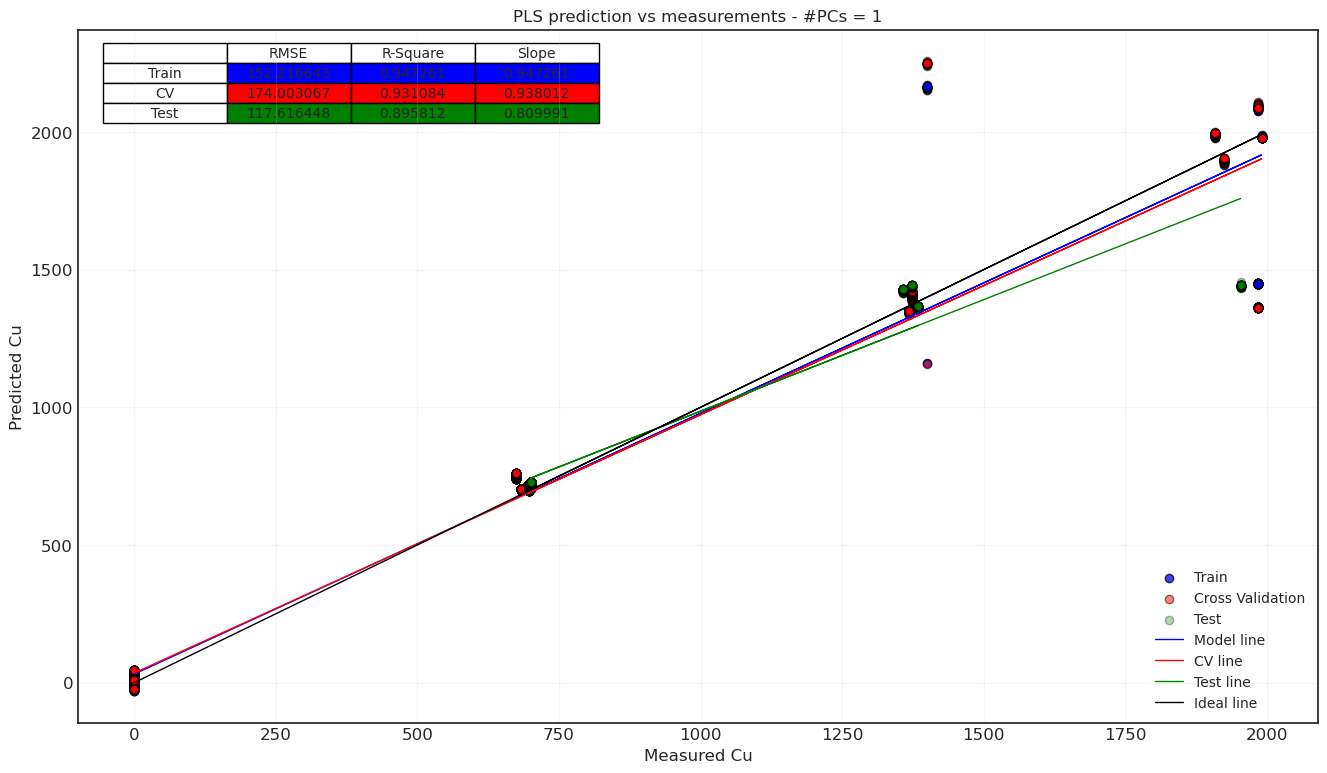

In [1588]:
regression_plot(y_pls_train[label_to_display], y_pred_train[label_to_display],
                y_pred_cv[label_to_display], y_pls_test[label_to_display],
                y_pred_test[label_to_display], rmse_train, r2_train,
                rmse_cv, r2_cv, rmse_test, r2_test,
                title = f"PLS prediction vs measurements - #PCs = {pls.best_estimator_.n_components}",
                variable = label_to_display)

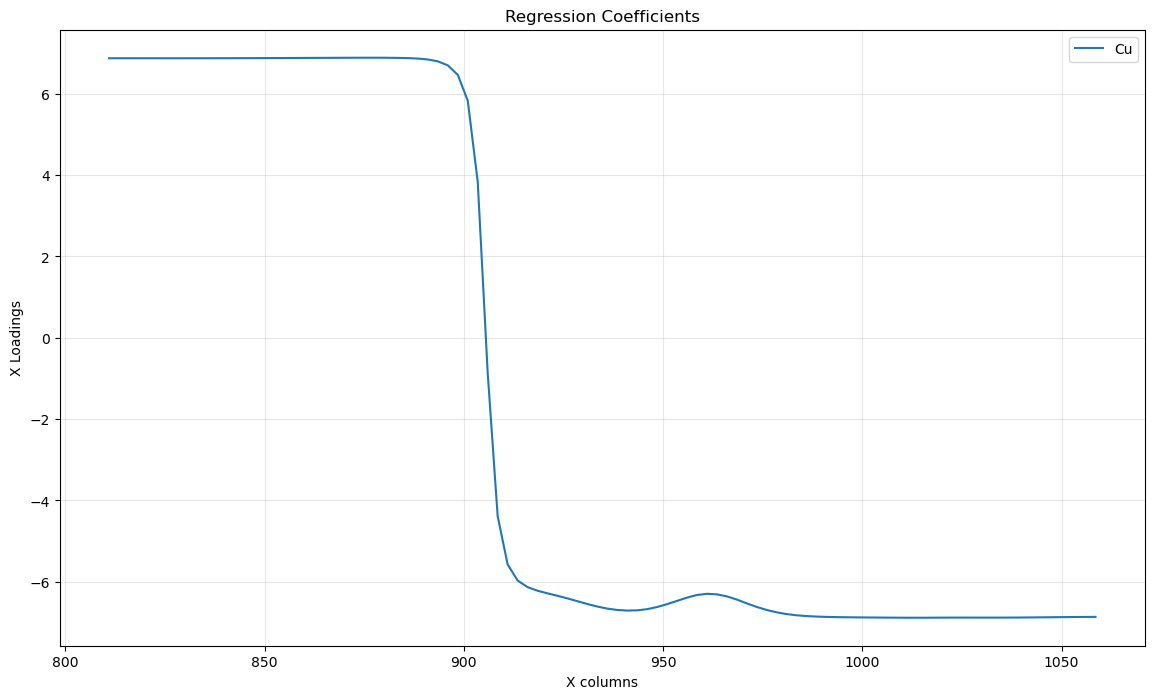

In [1589]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
plt.plot(X.columns, pls.best_estimator_.coef_[i], label=label_to_display)
plt.xlabel('X columns')
plt.ylabel('X Loadings')
plt.title('Regression Coefficients')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

In [1590]:
# Initial Results

In [1591]:
dict = {'Ref' : [],
        'Train/Test': [],
        'Mean': [],
        'STD': [],
        'MAE': [],
        'Relative Error %': []}

results_df = pd.DataFrame(dict)

for indx, i in enumerate(pls_group_train.unique()):
    ref = y_pls_train[label_to_display][pls_group_train.values == i].values.mean()
    class_ = 'Train'
    mean = y_pred_train[label_to_display][pls_group_train.values == i].values.mean()
    std = y_pred_train[label_to_display][pls_group_train.values == i].values.std()
    MAE = mean_absolute_error(y_pls_train[label_to_display][pls_group_train.values == i].values, y_pred_train[label_to_display][pls_group_train.values == i].values)
    denominator = y_pls_train[label_to_display][pls_group_train.values == i].values.mean()
    if denominator < 1:
        denominator = 1
    rel_err = MAE*100/np.abs(denominator)

    results_df.loc[indx] = [ref, class_, mean, std, MAE, rel_err]

df_length = results_df.shape[0]
for indx, i in enumerate(pls_group_test.unique()):
    ref = y_test[label_to_display][pls_group_test.values == i].values.mean()
    class_ = 'Test'
    mean = y_pred_test[label_to_display][pls_group_test.values == i].values.mean()
    std = y_pred_test[label_to_display][pls_group_test.values == i].values.std()
    MAE = mean_absolute_error(y_test[label_to_display][pls_group_test.values == i].values, y_pred_test[label_to_display][pls_group_test.values == i].values)
    denominator = y_test[label_to_display][pls_group_test.values == i].values.mean()
    if denominator < 1:
        denominator = 1
    rel_err = MAE*100/np.abs(denominator)

    results_df.loc[df_length + indx] = [ref, class_, mean, std, MAE, rel_err]

print('Summary:')
print('------------------------')
display(results_df)
print('_______________________________________________________')
display(results_df.describe())

Summary:
------------------------


,Ref,Train/Test,Mean,STD,MAE,Relative Error %
0,0.000000,Train,-7.814266,6.970516,7.814266,781.426570
1,694.493345,Train,714.508015,0.651627,20.014670,2.881910
2,1367.474116,Train,1348.990843,3.370364,18.483273,1.351636
3,1923.741739,Train,1893.213421,4.873542,30.528318,1.586924
4,0.000000,Train,-19.167499,1.046197,19.167499,1916.749936
5,683.737058,Train,702.094820,0.578891,18.357762,2.684915
6,1373.857455,Train,1407.525366,9.264861,33.667911,2.450612
7,1984.268039,Train,2086.300617,6.067119,102.032578,5.142076
8,0.000000,Train,33.316599,6.122290,33.316599,3331.659868
9,673.309975,Train,746.967793,2.747396,73.657818,10.939659


_______________________________________________________


,Ref,Mean,STD,MAE,Relative Error %
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1116.683880,1121.020398,13.687328,115.435267,335.892456
std,726.427896,721.120304,46.961132,205.995076,829.983063
min,0.000000,-19.167499,0.576870,7.814266,0.475814
25%,683.737058,704.772573,1.866636,18.483273,2.450612
50%,1367.474116,1363.514922,3.370364,30.528318,4.866187
75%,1909.177690,1449.035938,4.988575,73.657818,26.973797
max,1990.530895,2112.672321,218.390039,736.587945,3331.659868


## Model optimization 

### Outlier detection and removal

1. Outlier sorting using Q residuals and Hotelling's Tsquared

In [1592]:
ncomp = pls.best_estimator_.n_components

# Get X scores
T = pls.best_estimator_.x_scores_

# Get X loadings
P = pls.best_estimator_.x_loadings_
 
# Calculate error array
Err = x_pls_train - np.dot(T, P.T)
 
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)
 
# Calculate Hotelling's T-squared (note that data are normalised by default)
Tsq = np.sum((T/np.std(T, axis=0))**2, axis=1)

# set the confidence level
conf = 0.95
 

# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=(x_pls_train.shape[0]-ncomp))*ncomp*(x_pls_train.shape[0]-1)/(x_pls_train.shape[0]-ncomp)
 
# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0)> conf:
    i -= 1
Q_conf = i

2. Visualize the outliers

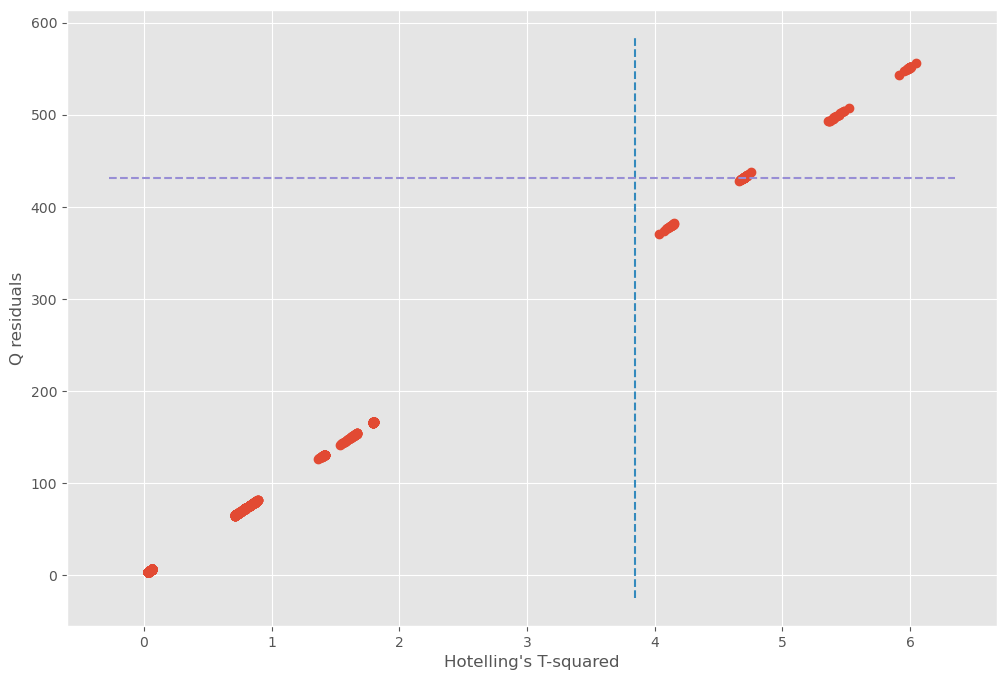

In [1593]:
ax = plt.figure(figsize=(12,8))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
 
plt.show()

3. Sort the data according to RMS distance from origin in descending order

In [1594]:
# Sort the RMS distance from the origin in descending order (largest first)
plscomp=pls.best_estimator_.n_components
 
rms_dist = np.flip(np.argsort(np.sqrt(Q**2+Tsq**2)), axis=0)
 
# Sort calibration spectra according to descending RMS distance
Xc = x_pls_train.iloc[rms_dist, :]
Yc = y_pls_train.iloc[rms_dist, :]
pls_group_train = pls_group_train.iloc[rms_dist]
 
# Discard one outlier at a time up to the value max_outliers
# and calculate the mse cross-validation of the PLS model

# Define empty mse array
rmse = np.zeros(max_outliers)
 
for j in range(max_outliers):
 
    pls_temp = PLSRegression(n_components=plscomp, scale=True)
    pls_temp.fit(Xc.iloc[j:, :], Yc.iloc[j:, :])
    group_kfold = GroupKFold(n_splits=Yc[label_to_display].iloc[j:].nunique()-1)
    y_cv = cross_val_predict(pls_temp, Xc.iloc[j:, :], Yc.iloc[j:, :], groups=Yc[label_to_display].iloc[j:], cv=group_kfold) 
    y_cv = pd.DataFrame(y_cv, columns=Yc.columns)
 
    rmse[j] = np.sqrt(mean_squared_error(Yc[label_to_display].iloc[j:], y_cv[label_to_display]))
 
# Find the position of the minimum in the mse (excluding the zeros)
rmsemin = np.where(rmse==np.min(rmse[np.nonzero(rmse)]))[0][0]
rmsemin_index = np.argmin(rmse, axis=0)

In [1595]:
print(f'Removed {rmsemin_index} outliers')

Removed 19 outliers


4. Create features and labels matrices without the outliers

In [1596]:
x_outliers_removed = Xc.iloc[rmsemin_index:, :]
y_outliers_removed = Yc.iloc[rmsemin_index:, :]
pls_group_train = pls_group_train.iloc[rmsemin_index:]


print('Features matrix rows without outliers: ', x_outliers_removed.shape[0])
print('Labels matrix rows without outliers: ', y_outliers_removed.shape[0])

Features matrix rows without outliers:  1315
Labels matrix rows without outliers:  1315


5. Repeat the steps of PLS regression on the filtered data

In [1597]:
x_pls2_train = x_outliers_removed
y_pls2_train = y_outliers_removed

In [1598]:
print(f'The features matrix to be modeled x_pls2_train shape: {x_pls2_train.shape}')
print(f'The labels matrix to be modeled y_pls2_train shape: {y_pls2_train.shape}')

The features matrix to be modeled x_pls2_train shape: (1315, 100)
The labels matrix to be modeled y_pls2_train shape: (1315, 1)


### Finding the best number of components for the model

1. Define the parameter space for the search

In [1599]:
parameters2 = {'n_components':np.arange(1,max_number_of_components+1,1)}

2. Define the grid-search estimator based on PLS regression

* define group k-fold

In [1600]:
# Define GroupKFold cross-validation
group_kfold = GroupKFold(n_splits=total_train_groups-1)
print(f'Group K-Fold: {group_kfold}')

Group K-Fold: GroupKFold(n_splits=15)


In [1601]:
pls2 = GridSearchCV(PLSRegression(scale=False), parameters2, scoring = 'neg_mean_squared_error', verbose=1, cv=group_kfold)

3. fit the model to the training data

In [1602]:
pls2.fit(x_pls2_train, y_pls2_train, groups=pls_group_train)

Fitting 15 folds for each of 7 candidates, totalling 105 fits


GridSearchCV(cv=GroupKFold(n_splits=15), estimator=PLSRegression(scale=False),
             param_grid={'n_components': array([1, 2, 3, 4, 5, 6, 7])},
             scoring='neg_mean_squared_error', verbose=1)

4. The best estimator result

In [1603]:
print(f'The number of components for the PLS model: \n{pls2.best_estimator_}')

The number of components for the PLS model: 
PLSRegression(n_components=1, scale=False)


4. Self prediction results

In [1604]:
y_pred_train2 = pls2.predict(x_pls2_train)
y_pred_train2 = pd.DataFrame(y_pred_train2, columns=selected_labels)

print(f'The self prediction matrix y_pred_train shape: {y_pred_train2.shape}')

The self prediction matrix y_pred_train shape: (1315, 1)


In [1605]:
rmse_train2, r2_train2 = np.sqrt(mean_squared_error(y_pls2_train[label_to_display], y_pred_train2[label_to_display])), \
r2_score(y_pls2_train[label_to_display], y_pred_train2[label_to_display])

### Applying cross validation for the model using the best estimator

1. Apply the best estimator to calculate a cross-validation predicted variable

In [1606]:
y_pred_cv2 = cross_val_predict(pls2.best_estimator_, x_pls2_train, y_pls2_train, groups=pls_group_train, cv=group_kfold)
y_pred_cv2 = pd.DataFrame(y_pred_cv2, columns=selected_labels)

print(f'The cross-validation prediction matrix y_cv shape: {y_pred_cv2.shape}')

The cross-validation prediction matrix y_cv shape: (1315, 1)


2. Calculate figures of merit

In [1607]:
rmse_cv2, r2_cv2 = np.sqrt(mean_squared_error(y_pls2_train[label_to_display], y_pred_cv2[label_to_display])), \
r2_score(y_pls2_train[label_to_display], y_pred_cv2[label_to_display])

### Validating the model using Test dataset

In [1608]:
y_pred_test2 = pls2.predict(x_test)
y_pred_test2 = pd.DataFrame(y_pred_test2, columns=selected_labels)

In [1609]:
rmse_test2, r2_test2 = np.sqrt(mean_squared_error(y_pls_test[label_to_display], y_pred_test2[label_to_display])), \
                                                  r2_score(y_pls_test[label_to_display], y_pred_test2[label_to_display])

3. Plot the results

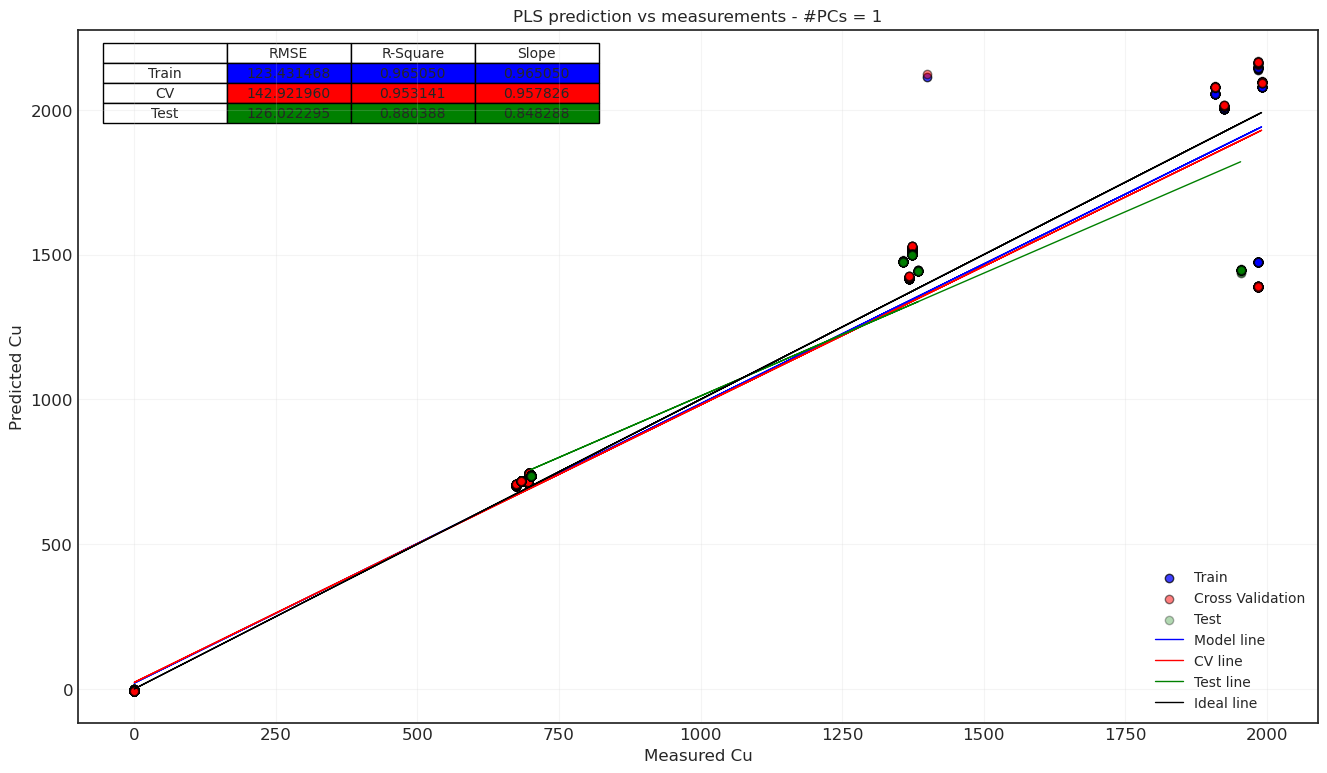

In [1610]:
regression_plot(y_pls2_train[label_to_display], y_pred_train2[label_to_display],
                y_pred_cv2[label_to_display], y_pls_test[label_to_display],
                y_pred_test2[label_to_display], rmse_train2, r2_train2,
                rmse_cv2, r2_cv2, rmse_test2, r2_test2,
                title = f"PLS prediction vs measurements - #PCs = {pls2.best_estimator_.n_components}",
                variable = label_to_display)

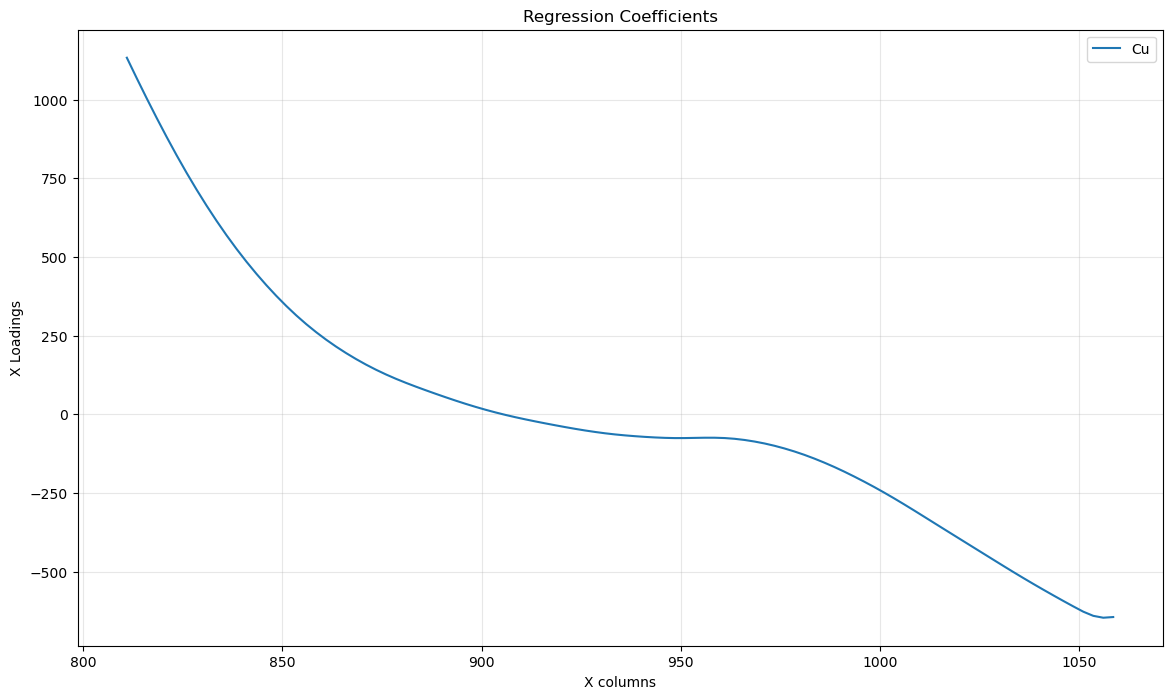

In [1611]:
for i, _label in enumerate(selected_labels):
    if label_to_display == _label:
        break
plt.plot(X.columns, pls2.best_estimator_.coef_[i], label=label_to_display)
plt.xlabel('X columns')
plt.ylabel('X Loadings')
plt.title('Regression Coefficients')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Final results

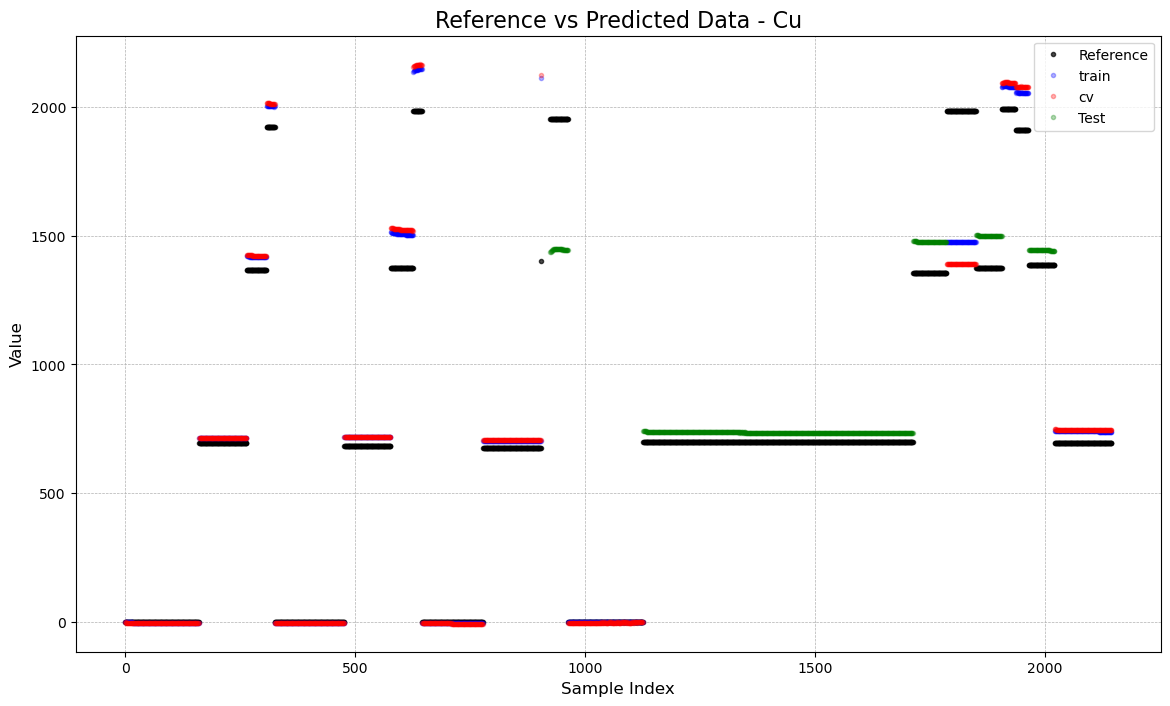

In [1612]:
plt.figure(figsize=(14, 8))

plt.plot(y_pls2_train.index, y_pls2_train[label_to_display],
         'ok', markersize=3, label=f"Reference", alpha=0.7)
plt.plot(y_test.index, y_test[label_to_display],
         'ok', markersize=3, alpha=0.7)
plt.plot(y_pls2_train.index, y_pred_train2[label_to_display],
         'ob', markersize=3, label=f"train", alpha=0.3)
plt.plot(y_pls2_train.index, y_pred_cv2[label_to_display],
         'or', markersize=3, label=f"cv", alpha=0.3)
plt.plot(y_test.index, y_pred_test2[label_to_display],
         'og', markersize=3, label=f"Test", alpha=0.3)

# Add title and labels
plt.title(f'Reference vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)

plt.show()

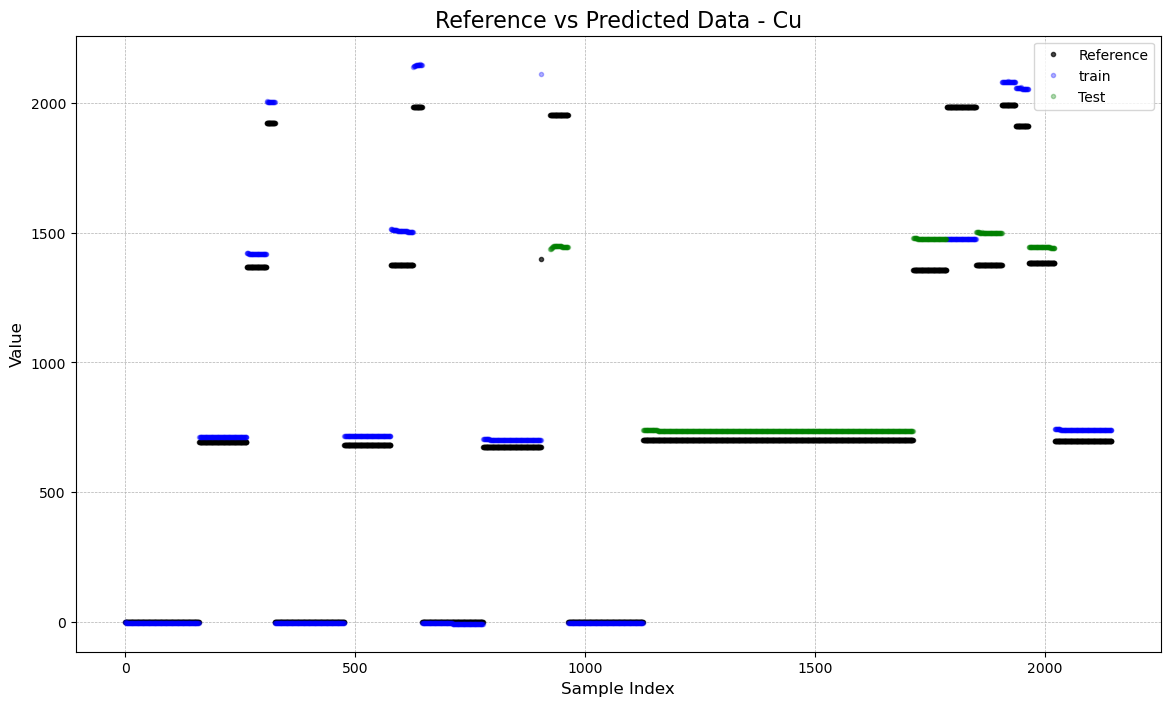

In [1613]:
plt.figure(figsize=(14, 8))

plt.plot(y_pls2_train.index, y_pls2_train[label_to_display],
         'ok', markersize=3, label=f"Reference", alpha=0.7)
plt.plot(y_test.index, y_test[label_to_display],
         'ok', markersize=3, alpha=0.7)
plt.plot(y_pls2_train.index, y_pred_train2[label_to_display],
         'ob', markersize=3, label=f"train", alpha=0.3)
# plt.plot(y_pls2_train.index, y_pred_cv2[label_to_display],
#          'or', markersize=3, label=f"cv", alpha=0.3)
plt.plot(y_test.index, y_pred_test2[label_to_display],
         'og', markersize=3, label=f"Test", alpha=0.3)

# Add title and labels
plt.title(f'Reference vs Predicted Data - {label_to_display}', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='best', fontsize=10)

plt.show()

In [1614]:
# for i, _label in enumerate(selected_labels):
#     if label_to_display == _label:
#         break
        
# coeff = pls2.best_estimator_.coef_[i]
# intercept = pls2.best_estimator_.intercept_[i]

# y_measured = scale(y_filtered[label_to_display])

# y_predicted = scale(X_filtered @ coeff.T + intercept)

# plt.plot(y_filtered.index, y_measured, 'o', markersize=3, label="Reference", alpha=0.6)
# plt.plot(X_filtered.index, y_predicted, 'o', markersize=3, label="Predicted", alpha=0.6)

# # Add title and labels
# plt.title(f'Reference vs Predicted Data - {label_to_display}', fontsize=16)
# plt.xlabel('Sample Index', fontsize=12)
# plt.ylabel('Value', fontsize=12)

# # Add grid
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Add legend
# plt.legend(loc='best', fontsize=10)
# plt.show()

# Summary of the model

In [1615]:
dict = {'Ref' : [],
        'Train/Test': [],
        'Mean': [],
        'STD': [],
        'MAE': [],
        'Relative Error %': []}

results_df = pd.DataFrame(dict)

for indx, i in enumerate(pls_group_train.unique()):
    ref = y_pls2_train[label_to_display][pls_group_train.values == i].values.mean()
    class_ = 'Train'
    mean = y_pred_train2[label_to_display][pls_group_train.values == i].values.mean()
    std = y_pred_train2[label_to_display][pls_group_train.values == i].values.std()
    MAE = mean_absolute_error(y_pls2_train[label_to_display][pls_group_train.values == i].values, y_pred_train2[label_to_display][pls_group_train.values == i].values)
    denominator = y_pls2_train[label_to_display][pls_group_train.values == i].values.mean()
    if denominator < 1:
        denominator = 1
    rel_err = MAE*100/np.abs(denominator)

    results_df.loc[indx] = [ref, class_, mean, std, MAE, rel_err]

df_length = results_df.shape[0]
for indx, i in enumerate(pls_group_test.unique()):
    ref = y_test[label_to_display][pls_group_test.values == i].values.mean()
    class_ = 'Test'
    mean = y_pred_test2[label_to_display][pls_group_test.values == i].values.mean()
    std = y_pred_test2[label_to_display][pls_group_test.values == i].values.std()
    MAE = mean_absolute_error(y_test[label_to_display][pls_group_test.values == i].values, y_pred_test2[label_to_display][pls_group_test.values == i].values)
    denominator = y_test[label_to_display][pls_group_test.values == i].values.mean()
    if denominator < 1:
        denominator = 1
    rel_err = MAE*100/np.abs(denominator)

    results_df.loc[df_length + indx] = [ref, class_, mean, std, MAE, rel_err]

print('Summary:')
print('------------------------')
display(results_df)
print('_______________________________________________________')
display(results_df.describe())

Summary:
------------------------


,Ref,Train/Test,Mean,STD,MAE,Relative Error %
0,1984.268039,Train,2144.752414,2.767227,160.484375,8.087838
1,1909.177690,Train,2055.625445,0.978884,146.447755,7.670724
2,1990.530895,Train,2079.808366,0.833679,89.277471,4.485109
3,1923.741739,Train,2003.166151,0.975648,79.424412,4.128642
4,1984.268485,Train,1474.740676,0.164228,509.527809,25.678370
5,1373.857455,Train,1506.683679,2.902781,132.826224,9.668123
6,1367.474116,Train,1417.887843,1.124449,50.413727,3.686631
7,0.000000,Train,-4.333938,0.995436,4.333938,433.393758
8,0.000000,Train,-3.518402,0.100019,3.518402,351.840215
9,0.000000,Train,-2.233046,0.108474,2.233046,223.304582


_______________________________________________________


,Ref,Mean,STD,MAE,Relative Error %
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1116.683880,1154.857917,0.971383,136.496562,82.353398
std,726.427896,750.979651,0.845877,194.155227,159.715572
min,0.000000,-5.353826,0.000000,2.233046,2.646868
25%,683.737058,712.875665,0.164228,28.870372,4.485109
50%,1367.474116,1443.732802,0.934603,59.101550,8.087838
75%,1909.177690,1506.683679,1.124449,132.826224,25.974407
max,1990.530895,2144.752414,2.902781,712.421584,535.382574


# Deep Neural Networks

In [1616]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # For this example, let's generate some dummy data
# N = X_filtered.shape[0] # Number of spectra
# M = X_filtered.shape[1]   # Number of features (wavelengths)
# K = 1#y_filtered[label_to_display]     # Number of concentration measurements

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered[label_to_display], test_size=0.2, random_state=42)

# # Scale the input features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Build the neural network model
# model = Sequential()
# model.add(Dense(128, input_dim=M, activation='relu'))  # Input layer
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(Dense(64, activation='relu'))  # Hidden layer
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(Dense(32, activation='relu'))  # Hidden layer
# model.add(Dense(K, activation='linear'))  # Output layer

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# # Train the model
# history = model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_split=0.2, verbose=0)

# # Evaluate the model
# loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
# print(f'Test Loss: {loss}, Test MAE: {mae}')

# # Predictions
# y_pred_train = model.predict(X_train_scaled)
# y_pred_test = model.predict(X_test_scaled)

# plt.plot(y_train.index, y_train, 'ok', markersize=3, label=f"Measured", alpha=0.75)
# plt.plot(y_test.index, y_test, 'ok', markersize=3, alpha=0.75)
# plt.plot(y_train.index, y_pred_train, '.b', markersize=3, label=f"train", alpha=0.3) 
# plt.plot(y_test.index, y_pred_test, '.g', markersize=3, label=f"test", alpha=0.3)

# # Add title and labels
# plt.title(f'Measured vs Predicted Data - {label_to_display}', fontsize=16)
# plt.xlabel('Sample Index', fontsize=12)
# plt.ylabel('Value', fontsize=12)

# # Add grid
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Add legend
# plt.legend(loc='best', fontsize=10)
# plt.show()


In [1617]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from sklearn.model_selection import GroupKFold
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Assuming X_filtered, y_filtered, and f_filtered are already defined
# N = X_filtered.shape[0]  # Number of spectra
# M = X_filtered.shape[1]  # Number of features (wavelengths)
# K = 1  # Number of concentration measurements (assuming single output)

# # Define group labels
# groups = y_filtered[label_to_display]

# # Scale the input features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_filtered)


# total_number_of_groups = y_filtered[group_by].nunique()
# test_groups_ratio = 0.2
# total_test_groups = int(np.ceil((test_groups_ratio)*total_number_of_groups)) 

# print(f'Total number of groups of label "{group_by}" = {total_number_of_groups}')
# print(f'Total number of test groups = {total_test_groups}')


# # Define the Group K-Fold cross-validator
# # gkf = GroupKFold(n_splits=total_test_groups)
# gkf = GroupShuffleSplit(n_splits=total_test_groups)


# # Define the model architecture function
# def create_model():
#     model = Sequential()
#     model.add(Dense(256, input_dim=M, activation='relu'))  # Input layer
#     model.add(Dropout(0.2))  # Dropout for regularization
#     model.add(Dense(128, activation='sigmoid'))  # Hidden layer
#     model.add(Dropout(0.2))  # Dropout for regularization
#     model.add(Dense(64, activation='relu'))  # Hidden layer
#     model.add(Dense(32, activation='relu'))  # Hidden layer
#     model.add(Dense(K, activation='linear'))  # Output layer

#     # Compile the model
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     return model

# # Perform Group K-Fold cross-validation
# fold_no = 1
# for train_idx, test_idx in gkf.split(X_scaled, y_filtered[label_to_display], groups):
#     print(f"Training fold {fold_no}")
    
#     X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
#     y_train, y_test = y_filtered[label_to_display].iloc[train_idx], y_filtered[label_to_display].iloc[test_idx]
    
#     model = create_model()
    
#     # Train the model
#     history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0)
    
#     # Evaluate the model
#     loss, mae = model.evaluate(X_test, y_test, verbose=1)
#     print(f"Fold {fold_no} - Test Loss: {loss}, Test MAE: {mae}")
    
#     # Predictions
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)
    
#     print(f"Predicted concentrations: {y_pred_test[:5]}")
#     print(f"Actual concentrations: {y_test[:5]}")

#     plt.plot(y_train.index, y_train, 'ok', markersize=3, label=f"Ref", alpha=0.75)
#     plt.plot(y_test.index, y_test, 'ok', markersize=3, alpha=0.75)
#     plt.plot(y_train.index, y_pred_train, '.b', markersize=3, label=f"train", alpha=0.3) 
#     plt.plot(y_test.index, y_pred_test, '.g', markersize=3, label=f"test", alpha=0.3)

#     # Add title and labels
#     plt.title(f'Measured vs Predicted Data - {label_to_display} - Fold {fold_no}', fontsize=16)
#     plt.xlabel('Sample Index', fontsize=12)
#     plt.ylabel('Value', fontsize=12)
    
#     # Add grid
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
#     # Add legend
#     plt.legend(loc='best', fontsize=10)
#     plt.show()

#     fold_no += 1
